In [1]:
import time
import sys
import os
from PIL import Image
import numpy as np
import cv2


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import warnings
warnings.simplefilter("ignore")

## Problem Statement
Image classification is an exciting subclass of computer vision. Important uses cases for image classification include identifying cancer in X-rays or allowing self-driving cars to identify objects in the road. For this project the use case could be to enable online retailers to identify the name of the team based on a picture of a logo. This project aims to classify the images of the logos of 31 of the 32 NFL teams. The Washington Football Team is not being included in this analysis since the team has no current logo and will not have a new logo until 2022. This project will use deep learning to create a robust CNN model that classify NFL team logo images with very high accuracy.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 24 15:42:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset used in this project.

---

We have downloaded logos for 31 of the 32 NFL teams, except for the Washington Football Team (WFT). WFT dropped it's previous logo, and will not have a new logo until 2022, and so only the other 31 NFL team logos are included in this analysis. The images used in the project can be downloaded from [google drive](https://drive.google.com/drive/folders/1aM-0xHmFzcPjx1pa0hImghVUhezYLkfa). 

Let's examine how many images are in each folder for the 31 NFL teams.

In [4]:
train_dir = '/content/drive/MyDrive/train/'
labels = os.listdir(train_dir)
print("No. of labels: {}".format(len(labels)))
print("-----------------")
os.chdir(train_dir)
for label in labels:
    print("{}, {} files".format(label, len(os.listdir(train_dir+ '//' +label))))


No. of labels: 31
-----------------
Atlanta Falcons, 226 files
Arizona Cardinals, 217 files
Baltimore Ravens, 224 files
Buffalo Bills, 215 files
Carolina Panthers, 221 files
Chicago Bears, 226 files
Cincinnati Bengals, 229 files
Cleveland Browns, 220 files
Dallas Cowboys, 221 files
Denver Broncos, 219 files
Detroit Lions, 219 files
Green Bay Packers, 228 files
Houston Texans, 219 files
Indianapolis Colts, 220 files
Jacksonville Jaguars, 219 files
Kansas City Chiefs, 208 files
Las Vegas Raiders, 219 files
Miami Dolphins, 220 files
Minnesota Vikings, 218 files
New England Patriots, 217 files
New Orleans Saints, 220 files
Philadelphia Eagles, 209 files
Pittsburgh Steelers, 223 files
San Francisco 49ers, 210 files
Seattle Seahawks, 220 files
Tampa Bay Buccaneers, 221 files
Tennessee Titans, 219 files
NY Jets, 220 files
NY Giants, 220 files
LA Chargers, 222 files
LA Rams, 224 files


Next, we will plot 10 images from the Green Bay Packers.

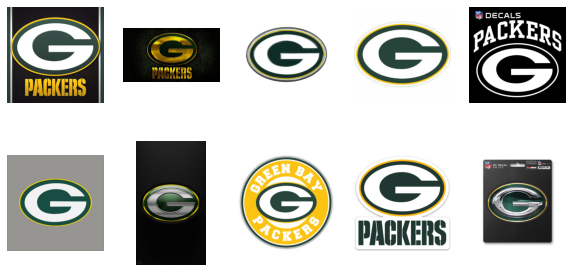

In [5]:
packers = '/content/drive/MyDrive/train/Green Bay Packers'
sub_class = os.listdir(packers)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(packers,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

### Data Augmentation.

---
Since we only have around 200 images from each class, we will use data augmentation.  

"_Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better._"

--- (Page 152). 
Chollet François. (2018). Deep learning with python. Manning Publications Co.  

We will use the ImageDataGenerator class from Keras to perform data augmentation. 

In [6]:
img_datagen = ImageDataGenerator(rescale=1./255,
                                vertical_flip=True,
                                horizontal_flip=True,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.1,
                                validation_split=0.2)
                                
#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = img_datagen.flow_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=32,
                                                 subset='training',
                                                 target_size=(100,100))
                                                 
valid_generator = img_datagen.flow_from_directory(train_dir,
                                                 shuffle=True,
                                                 batch_size=16,
                                                 subset='validation',
                                                 target_size=(100,100))

# Create a lablel_map dictionary that we will use for predicting on unseen data
label_map = (train_generator.class_indices)
print('Label mappings:\n')
label_map

Found 5463 images belonging to 31 classes.
Found 1350 images belonging to 31 classes.
Label mappings:



{'Arizona Cardinals': 0,
 'Atlanta Falcons': 1,
 'Baltimore Ravens': 2,
 'Buffalo Bills': 3,
 'Carolina Panthers': 4,
 'Chicago Bears': 5,
 'Cincinnati Bengals': 6,
 'Cleveland Browns': 7,
 'Dallas Cowboys': 8,
 'Denver Broncos': 9,
 'Detroit Lions': 10,
 'Green Bay Packers': 11,
 'Houston Texans': 12,
 'Indianapolis Colts': 13,
 'Jacksonville Jaguars': 14,
 'Kansas City Chiefs': 15,
 'LA Chargers': 16,
 'LA Rams': 17,
 'Las Vegas Raiders': 18,
 'Miami Dolphins': 19,
 'Minnesota Vikings': 20,
 'NY Giants': 21,
 'NY Jets': 22,
 'New England Patriots': 23,
 'New Orleans Saints': 24,
 'Philadelphia Eagles': 25,
 'Pittsburgh Steelers': 26,
 'San Francisco 49ers': 27,
 'Seattle Seahawks': 28,
 'Tampa Bay Buccaneers': 29,
 'Tennessee Titans': 30}

## Creating a baseline CNN model using Keras.

---

Next, we will instantiate a Sequential model and add 6 convolutional and maxpooling layers. We will also add two dropout layers to avoid overfitting. 

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(100,100,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(len(label_map)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        3

To avoid overfitting, we will use the EarlyStopping class to monitor the validation accuracy and stop training the model if the accuracy does not improve after 3 epochs (patience=4).

---



In [ ]:
callbacks_list = [EarlyStopping( monitor='accuracy', patience=4, ),
                  ModelCheckpoint( filepath='/content/drive/MyDrive/train results/models/keras_nfl_logo_model.h5',
                                  monitor='val_accuracy', save_best_only=True, ) ]


Next, we compile the model using the adam optimizer and the categoical_crossentropy loss function since this is a multi-class classification problem.

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, validation_data=valid_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_steps=valid_generator.n//valid_generator.batch_size,
                    callbacks=[callbacks_list],
                    epochs=50)

Epoch 1/50
170/170 [==============================] - 5124s 30s/step - loss: 3.3903 - accuracy: 0.0361 - val_loss: 3.0678 - val_accuracy: 0.0677
Epoch 2/50
170/170 [==============================] - 121s 712ms/step - loss: 3.0830 - accuracy: 0.0784 - val_loss: 2.8142 - val_accuracy: 0.1302
Epoch 3/50
170/170 [==============================] - 120s 705ms/step - loss: 2.8143 - accuracy: 0.1320 - val_loss: 2.4798 - val_accuracy: 0.1860
Epoch 4/50
170/170 [==============================] - 120s 705ms/step - loss: 2.5972 - accuracy: 0.1560 - val_loss: 2.2852 - val_accuracy: 0.2500
Epoch 5/50
170/170 [==============================] - 119s 703ms/step - loss: 2.4256 - accuracy: 0.2068 - val_loss: 2.1327 - val_accuracy: 0.2589
Epoch 6/50
170/170 [==============================] - 118s 698ms/step - loss: 2.3002 - accuracy: 0.2357 - val_loss: 1.9551 - val_accuracy: 0.3058
Epoch 7/50
170/170 [==============================] - 118s 697ms/step - loss: 2.1791 - accuracy: 0.2845 - val_loss: 1.8004 - 

### Plotting baseline model training and validation curves.

---
Next, we will plot the training and validation accuracy and loss curves.

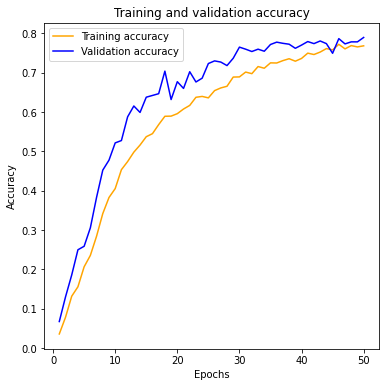

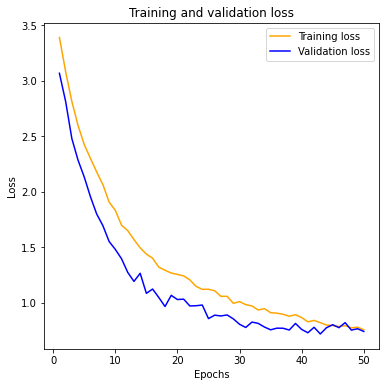

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_accuracy) + 1)
plt.figure(figsize=(6,6))
plt.plot(epochs, training_accuracy, 'orange', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(6,6))

plt.plot(epochs, training_loss, 'orange', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


From the above training and validation curves, we can see that the validation scores are better than the training scores across almost all epochs. This is likely due to the two dropout layers in the model. The dropout layers prevent all of the nodes from being used during training, but the nodes are fully available during validation. Next, we will make predictions with the best performing model that was saved during early stopping.

### Predicting on unseen Images

---



Next, we will load the saved model and make predictions on unseen data. Since the predictions return an array of probabilities for the associated label_map, we need to calculate the index of the highest probability and return the associated label from the label_map dictionary. We will create a key_list and value_list to do this.

In [7]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/train results/models/keras_nfl_logo_model.h5')

key_list = list(label_map.keys())
val_list = list(label_map.values())

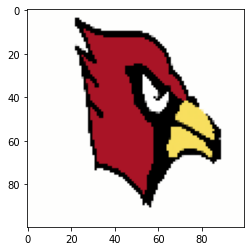

Top Prediction: Arizona Cardinals
Probability = 66.085%


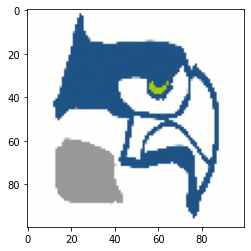

Top Prediction: Seattle Seahawks
Probability = 99.999%


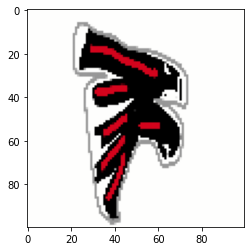

Top Prediction: Atlanta Falcons
Probability = 99.980%


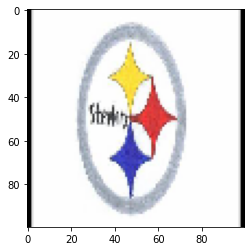

Top Prediction: Pittsburgh Steelers
Probability = 99.981%


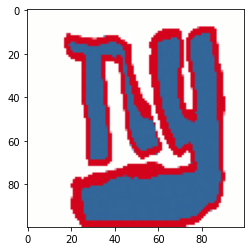

Top Prediction: NY Giants
Probability = 90.226%


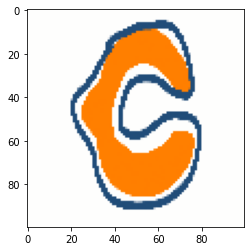

Top Prediction: Denver Broncos
Probability = 75.595%


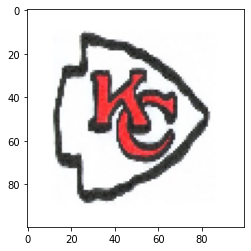

Top Prediction: Kansas City Chiefs
Probability = 34.769%


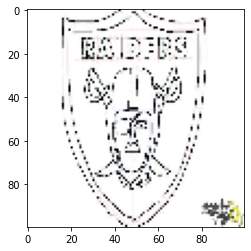

Top Prediction: Las Vegas Raiders
Probability = 76.086%


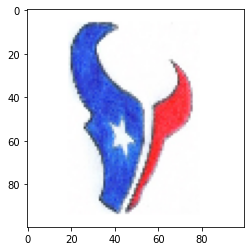

Top Prediction: Denver Broncos
Probability = 41.844%


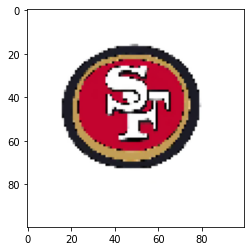

Top Prediction: San Francisco 49ers
Probability = 66.617%


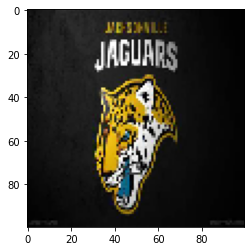

Top Prediction: Jacksonville Jaguars
Probability = 99.999%


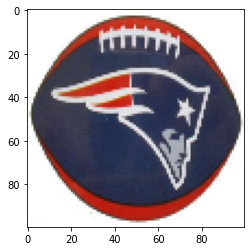

Top Prediction: New England Patriots
Probability = 43.442%


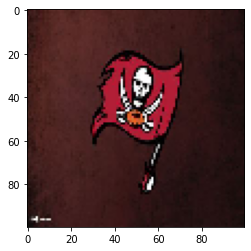

Top Prediction: Tampa Bay Buccaneers
Probability = 99.986%


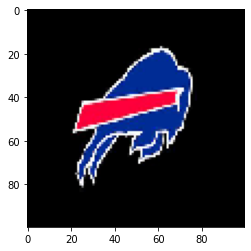

Top Prediction: Buffalo Bills
Probability = 99.938%


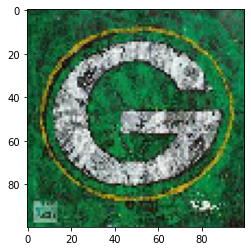

Top Prediction: NY Jets
Probability = 61.329%


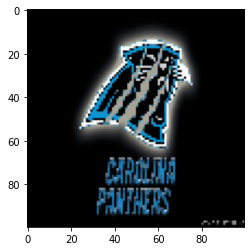

Top Prediction: Carolina Panthers
Probability = 99.998%


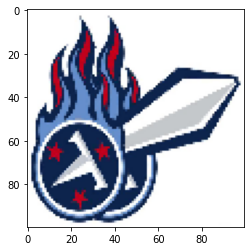

Top Prediction: Tennessee Titans
Probability = 99.999%


In [8]:
# Define the path for unseen images 
img_path = '/content/drive/MyDrive/unseen_images'
images = os.listdir(img_path)

# Iterate over the images and make predictions for each one
for i,name in enumerate(images):
  
  # Load and show the image
  img = image.load_img(img_path+'/'+name, target_size=(100,100))
  plt.imshow(img)
  plt.show()

  # Preprocess the image
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.

  # Make a prediction
  preds = loaded_model.predict(img_tensor)
  
  # Calculate the largest probability
  largest_pred = preds.argmax()
  
  print('Top Prediction: ' + key_list[val_list.index(largest_pred)])
  print('Probability = ' + str(preds.max()*100)[:6]+'%')
  

## Building a model on top of the ResNet50 model architecture.

---
Next, we will use the fastai library to build a model on top of the pretrained ResNet50 model. First we import the fastai library and setup the data using the ImageDataBunch.from_folder function. This function automatically infers the class names. We can also perform image augmentation if necessary, setup the validation set, image size, and batch size.

In [ ]:
np.random.seed(42)
from fastai.metrics import accuracy
from fastai.vision import *
from fastai.widgets import *

data = ImageDataBunch.from_folder(
    train_dir,
    valid_pct=0.2,
    ds_tfms=get_transforms(do_flip=False),
    size=224,
    num_workers=4,
    bs=64
)

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5451 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Atlanta Falcons,Atlanta Falcons,Atlanta Falcons,Atlanta Falcons,Atlanta Falcons
Path: /content/drive/MyDrive/train;

Valid: LabelList (1362 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Minnesota Vikings,Indianapolis Colts,Cincinnati Bengals,Detroit Lions,LA Chargers
Path: /content/drive/MyDrive/train;

Test: None

Next, we will use the show_batch function to show some of the images.

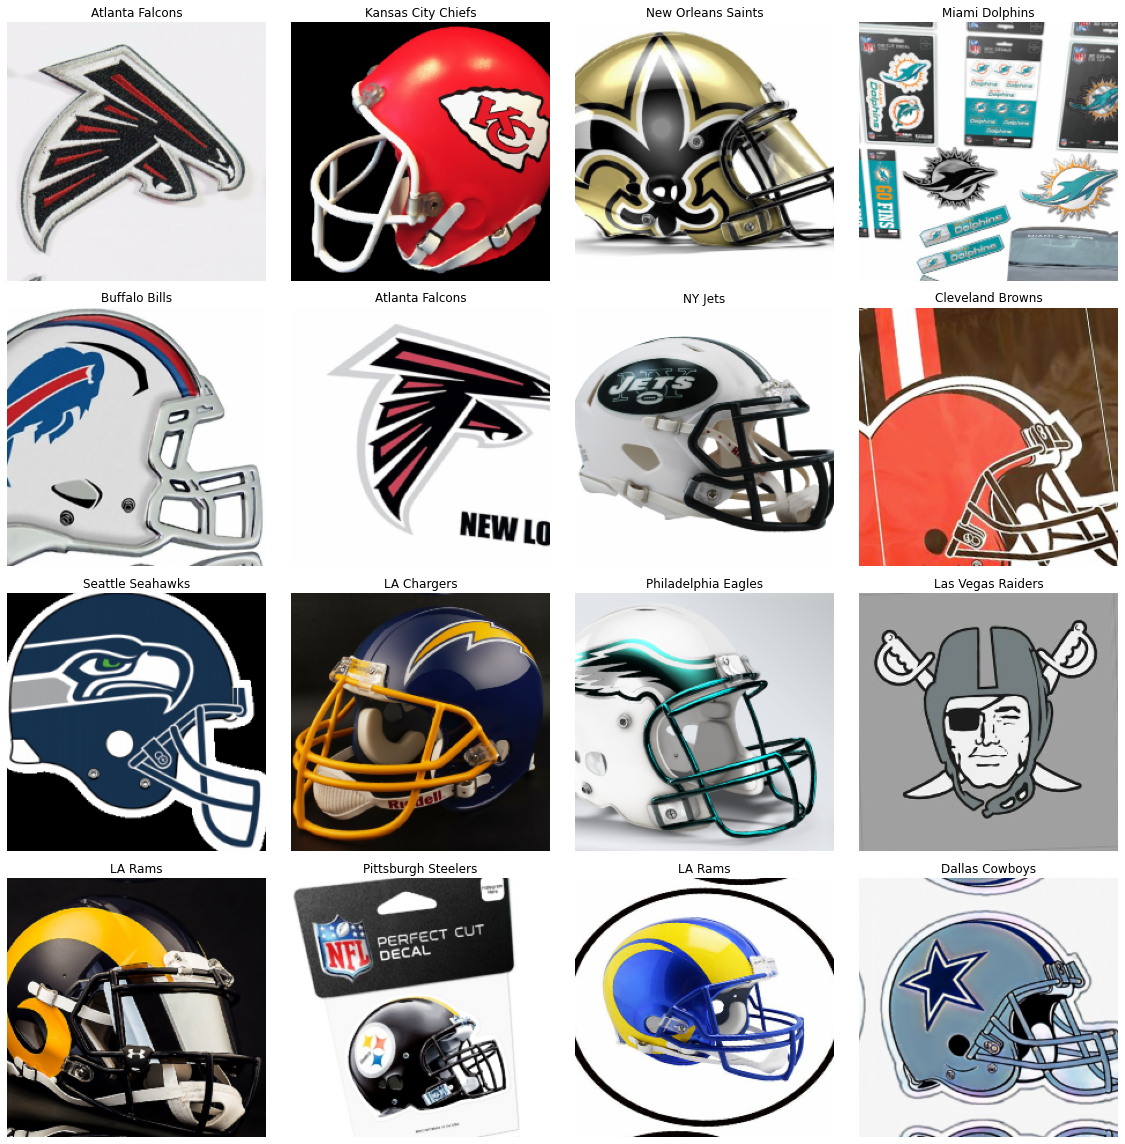

In [ ]:
data.show_batch(rows=4, figsize=(16,16))

### Downloading and using the ResNet50 model.

---
Next, we will load the resnet50 model, and train the model on the dataset for 5 epochs.

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(5)

### Adding layers on top of the ResNet50 model architecture.

---
From above, we can see that we achieved almost 91% accuracy without any tuning of the model.  
Next, we will unfreeze the top layers of ResNet50, and find an optimal learning rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 6.31E-08


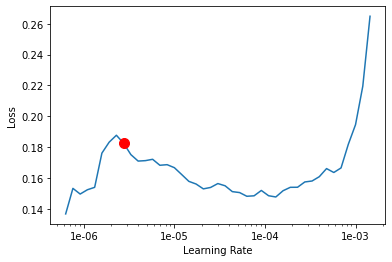

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Adjusting the learning rate for the new model.

---
Looking at the graph, we will choose the learning rate(lr = 0.001), as it is very close to a corresponding minimum loss. We will use this lr and fit the model for 5 epochs.

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(5, 0.0001)

The model accuracy increaded to 96.8%, which is nearly a 6% improvement over using the ResNet50 model with no tuning.  
Next, we will save the model.

In [ ]:
learn.save("/content/drive/MyDrive/train results/models/fastai_nfl_logo_model")


Fastai allows you to view the images with the highest loss values by using the DatasetFormatter().from_toplosses function. This function enabled me to delete several logos that had obscured logos, or in one case, an [incorrect logo](https://drive.google.com/file/d/1PH6_2HKgELk7V7PJSUJr2L-Fx29X6zEY/view?usp=sharing) that I overlooked during data collection.

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn)


In [ ]:
ImageCleaner(ds, idxs, train_dir)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

After the chosen toplosses images are marked for deletion, fastai automatically creates a csv file with the updated image information. The csv file can be loaded into a df and a new model can be built using the updated data.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train results/cleaned.csv', header='infer')

db = ImageList.from_df(df, train_dir).\
               split_by_rand_pct(0.2).\
               label_from_df().\
               transform(get_transforms(), size=224).\
               databunch(bs=8)
          
db.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (4345 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Atlanta Falcons,Atlanta Falcons,Atlanta Falcons,Atlanta Falcons,Atlanta Falcons
Path: /content/drive/MyDrive/train;

Valid: LabelList (1086 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Las Vegas Raiders,Tampa Bay Buccaneers,LA Chargers,Miami Dolphins,NY Giants
Path: /content/drive/MyDrive/train;

Test: None

### Retraining the saved model using the updated data.


---
Next, we will load the saved model and then update the data with the info from the cleaned image df.

In [ ]:
learn.load("fastai_nfl_logo_model") # Loading the weights
learn.data = db # Replacing the data

In [ ]:
learn.freeze()
learn.fit_one_cycle(3)

We can see from above that removing the incorrect or noisy images led to a final accuracy score of 98.8%. This is an excellent result! We will now save this model.

In [ ]:
learn.save("/content/drive/MyDrive/train results/models/fastai_nfl_logo_model_final")

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

### Plotting images with the highest losses.

---
Next, we can plot the images that had the highest loss values to examine them.

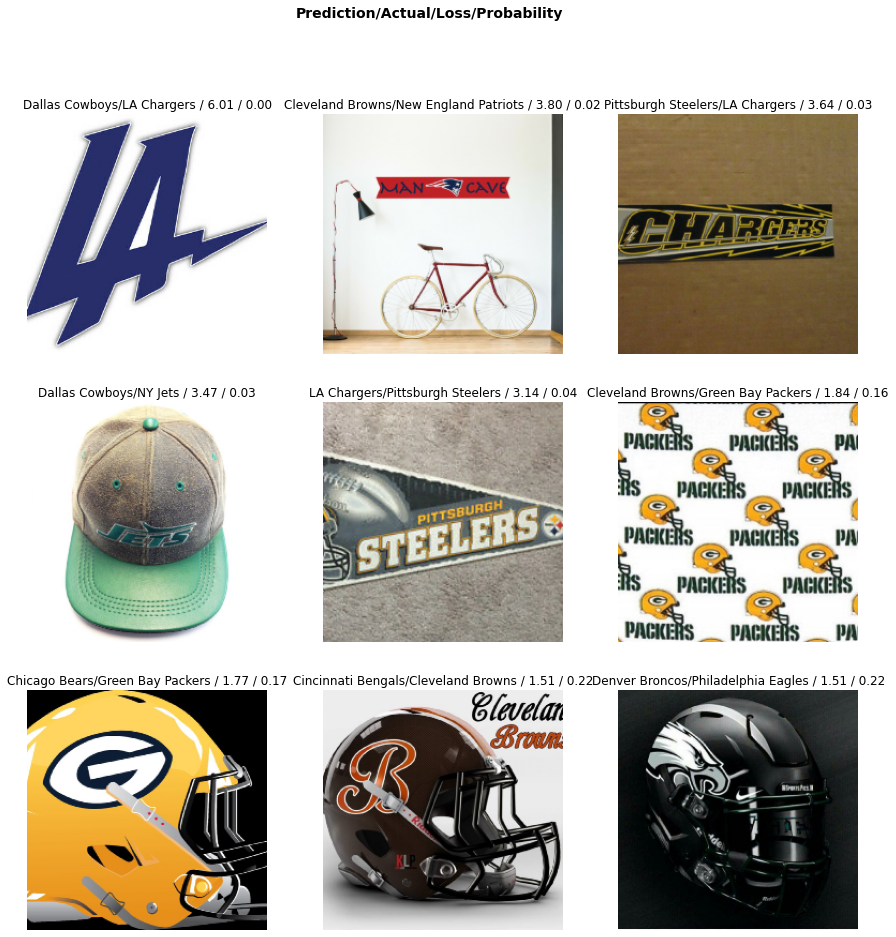

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

From above, we can see that some of the misclassified logos have a very small part of the image that is the actual logo, and a lot of useless information that confused the model. 

### Plotting the confusion matrix of the final fastai model.

---

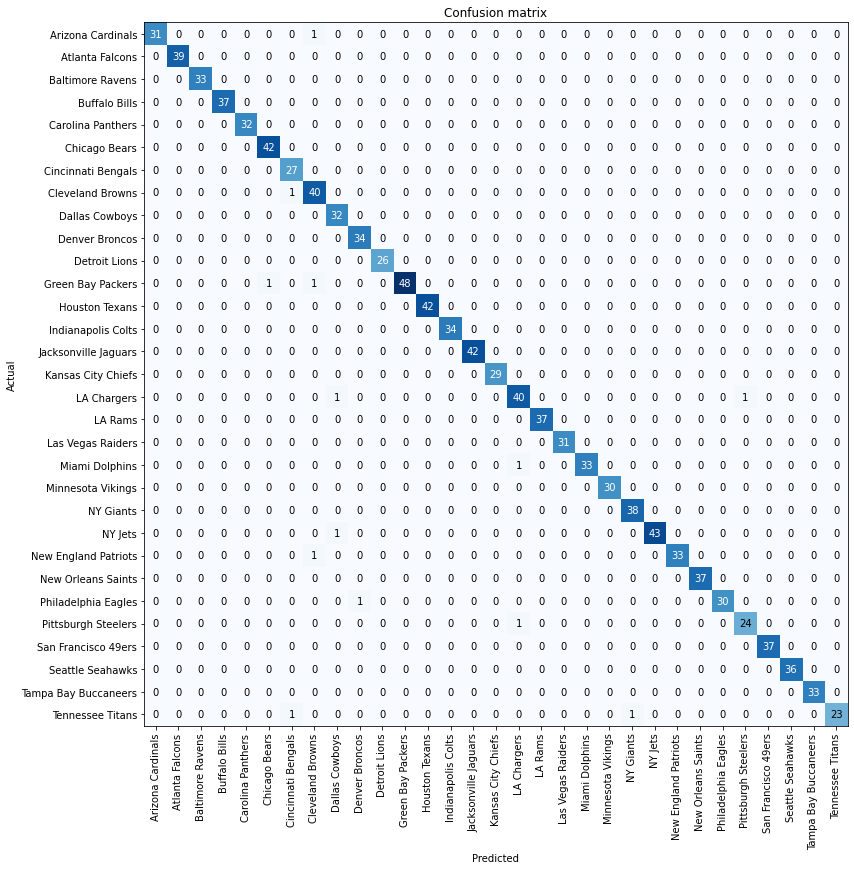

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12))

### Conclusions.

---
  
To recap, we first built a CNN from scratch in Keras and achieved a validation accuracy of 78.9%. Then, we used the fastai library to build a baseline model on top of the ResNet50 model and achieved a validation accuracy of 91%. We then tuned the model and the validation accuracy increased to 96.8%. Next, we used the fastai toplosses function and removed noisy images and one incorrect image. Finally, we used the updated data to build a model with an excellent validation accuracy of 98.8%.  
Overall, I am happy the increases in accuracy of the different models. While I have some previous experience in Keras, this project was my first time using the fastai library, and I was extremely impressed with the results. Fastai is a powerful low-code library that uses PyTorch to easily build deep learning models. 

The most challenging part of this project was curating the image datasets. While I found a programmatic solution for identifying and deleting images of the same size, I could not find a solution for identifying images that were incorrectly labeled by the image search engine. As a result, it was necessary to manually view each image to filter out the incorrectly labeled images, otherwise model accuracy would be limited by the image search engine's model accuracy. 